Notebook that is using gensim word2vec to discover correlated phonenumbers in call detail records.



In [2]:
import numpy as np
import pandas as pd
import logging
import multiprocessing
from gensim.models import Word2Vec
from time import time  

In [3]:
df = pd.read_csv("cdrlist_v5_10_300.csv",sep=",", names=['Label', 'SourceLabel', 'TargetLabel','Source','Target'],dtype = {'Label': int,'SourceLabel': str,
                                                      'TargetLabel': str,'Source': str, 'Target':str})
df.head(10)

,Label,SourceLabel,TargetLabel,Source,Target
0,0,Heather Morris,James Lawrence,+3163337174,+3164418934
1,1,Heather Morris,Ronnie Cook,+3163337174,+3168517169
2,2,Fred Jones,Susan Wong,+3162997281,+3162564217
3,3,Martha Batista,Charles Whaley,+3168197443,+3168517485
4,4,Maxine Kiefer,Willie Kahl,+3161876828,+3161785277
5,5,Willie Kahl,Maxine Kiefer,+3161785277,+3161876828
6,6,Maxine Kiefer,Willie Kahl,+3161876828,+3161785277
7,7,Susan Wong,Martha Batista,+3162564217,+3168197443
8,8,Ronnie Cook,Heather Morris,+3168517169,+3163337174
9,9,Ronnie Cook,Heather Morris,+3168517169,+3163337174


In [4]:
df['Target'].head(10)


0    +3164418934
1    +3168517169
2    +3162564217
3    +3168517485
4    +3161785277
5    +3161876828
6    +3161785277
7    +3168197443
8    +3163337174
9    +3163337174
Name: Target, dtype: object

Need to convert this into sentences  (see https://rare-technologies.com/word2vec-tutorial/)


In [5]:
np=df.to_numpy()
sentences = np[:,[3,4,3,4]].tolist()
sentences[:10]

[['+3163337174', '+3164418934', '+3163337174', '+3164418934'],
 ['+3163337174', '+3168517169', '+3163337174', '+3168517169'],
 ['+3162997281', '+3162564217', '+3162997281', '+3162564217'],
 ['+3168197443', '+3168517485', '+3168197443', '+3168517485'],
 ['+3161876828', '+3161785277', '+3161876828', '+3161785277'],
 ['+3161785277', '+3161876828', '+3161785277', '+3161876828'],
 ['+3161876828', '+3161785277', '+3161876828', '+3161785277'],
 ['+3162564217', '+3168197443', '+3162564217', '+3168197443'],
 ['+3168517169', '+3163337174', '+3168517169', '+3163337174'],
 ['+3168517169', '+3163337174', '+3168517169', '+3163337174']]

Compile a reverse phonebook so we can convert a phonenumber to a person (a person can have multiple phone numbers)

Create an gensim word2vec model and train it. Use the 3 step approach exaplained in Kaggle word2vec https://www.kaggle.com/pierremegret/gensim-word2vec-tutorial

In [21]:
w2v_model = Word2Vec(min_count=1,
                     window=5,
                     size=100,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=5,
                     workers=1)

Now build the vocabulary of our word2vec model

In [22]:
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

t = time()

w2v_model.build_vocab(sentences, progress_per=10000)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 13:59:17: collecting all words and their counts
INFO - 13:59:17: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 13:59:17: collected 38 word types from a corpus of 12000 raw words and 3000 sentences
INFO - 13:59:17: Loading a fresh vocabulary
INFO - 13:59:17: effective_min_count=1 retains 38 unique words (100% of original 38, drops 0)
INFO - 13:59:17: effective_min_count=1 leaves 12000 word corpus (100% of original 12000, drops 0)
INFO - 13:59:17: deleting the raw counts dictionary of 38 items
INFO - 13:59:17: sample=6e-05 downsamples 38 most-common words
INFO - 13:59:17: downsampling leaves estimated 565 word corpus (4.7% of prior 12000)
INFO - 13:59:17: estimated required memory for 38 words and 100 dimensions: 49400 bytes
INFO - 13:59:17: resetting layer weights


Time to build vocab: 0.0 mins


Next we train the model

In [64]:
t = time()

w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=100000, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

w2v_model.wv.save("cdr_v5_48_250000")

Streaming output truncated to the last 5000 lines.
INFO - 16:35:21: worker thread finished; awaiting finish of 0 more threads
INFO - 16:35:21: EPOCH - 97503 : training on 12000 raw words (567 effective words) took 0.0s, 61047 effective words/s
INFO - 16:35:21: worker thread finished; awaiting finish of 0 more threads
INFO - 16:35:21: EPOCH - 97504 : training on 12000 raw words (571 effective words) took 0.0s, 61013 effective words/s
INFO - 16:35:21: worker thread finished; awaiting finish of 0 more threads
INFO - 16:35:21: EPOCH - 97505 : training on 12000 raw words (578 effective words) took 0.0s, 119421 effective words/s
INFO - 16:35:21: worker thread finished; awaiting finish of 0 more threads
INFO - 16:35:21: EPOCH - 97506 : training on 12000 raw words (543 effective words) took 0.0s, 49129 effective words/s
INFO - 16:35:21: worker thread finished; awaiting finish of 0 more threads
INFO - 16:35:21: EPOCH - 97507 : training on 12000 raw words (576 effective words) took 0.0s, 45670 e

Time to train the model: 29.72 mins


These are the different numbers for each person

In [29]:
# v5
number2name = {'+3164418934': 'James Lawrence', '+3168398441': 'William Lee', '+3162997281': 'Fred Jones', '+3168517485': 'Charles Whaley', '+3161785277': 'Willie Kahl', '+3165007072': 'Jessica Weathers', '+3168517169': 'Ronnie Cook', '+3163337174': 'Heather Morris', '+3162564217': 'Susan Wong', '+3166273233': 'Tamika Nieto', '+3162710343': 'Ricky Rosenberg', '+3169049278': 'Jennifer Harvey', '+3168897858': 'Megan Towne', '+3160009594': 'Antonio Tweed', '+3165438436': 'Ken Walson', '+3168197443': 'Martha Batista', '+3160326765': 'Sandra Goodwin', '+3161876828': 'Maxine Kiefer', '+3166089806': 'Randy Howard', '+3165159230': 'William Drake', '+3163867786': 'Susan Wong0', '+3163231028': 'Charles Whaley0', '+3169411442': 'Antonio Tweed1', '+3169340543': 'William Drake1', '+3166813102': 'Heather Morris2', '+3167609207': 'Tamika Nieto2', '+3168106820': 'William Drake3', '+3160263935': 'Martha Batista3', '+3165060836': 'James Lawrence4', '+3168686388': 'Ronnie Cook4', '+3169857890': 'William Drake5', '+3167039616': 'Sandra Goodwin5', '+3162700047': 'Susan Wong6', '+3164203716': 'Tamika Nieto6', '+3169645334': 'Megan Towne7', '+3164380657': 'James Lawrence7', '+3165283223': 'Ronnie Cook8', '+3164629792': 'James Lawrence8', '+3165706197': 'Ronnie Cook9', '+3168785019': 'Martha Batista9'}
name2number = {'James Lawrence': '+3164418934', 'William Lee': '+3168398441', 'Fred Jones': '+3162997281', 'Charles Whaley': '+3168517485', 'Willie Kahl': '+3161785277', 'Jessica Weathers': '+3165007072', 'Ronnie Cook': '+3168517169', 'Heather Morris': '+3163337174', 'Susan Wong': '+3162564217', 'Tamika Nieto': '+3166273233', 'Ricky Rosenberg': '+3162710343', 'Jennifer Harvey': '+3169049278', 'Megan Towne': '+3168897858', 'Antonio Tweed': '+3160009594', 'Ken Walson': '+3165438436', 'Martha Batista': '+3168197443', 'Sandra Goodwin': '+3160326765', 'Maxine Kiefer': '+3161876828', 'Randy Howard': '+3166089806', 'William Drake': '+3165159230', 'Susan Wong0': '+3163867786', 'Charles Whaley0': '+3163231028', 'Antonio Tweed1': '+3169411442', 'William Drake1': '+3169340543', 'Heather Morris2': '+3166813102', 'Tamika Nieto2': '+3167609207', 'William Drake3': '+3168106820', 'Martha Batista3': '+3160263935', 'James Lawrence4': '+3165060836', 'Ronnie Cook4': '+3168686388', 'William Drake5': '+3169857890', 'Sandra Goodwin5': '+3167039616', 'Susan Wong6': '+3162700047', 'Tamika Nieto6': '+3164203716', 'Megan Towne7': '+3169645334', 'James Lawrence7': '+3164380657', 'Ronnie Cook8': '+3165283223', 'James Lawrence8': '+3164629792', 'Ronnie Cook9': '+3165706197', 'Martha Batista9': '+3168785019'}


What does a single vector look like

In [65]:
print('James Lawrence =', w2v_model[name2number['James Lawrence']])


James Lawrence = [-0.36273277  0.11420755  0.04792392 -0.57395864 -0.13329509 -1.536167
 -0.10277307  0.80342346 -0.09167212 -0.46111524 -0.07223477  0.68059886
 -0.25744796 -0.07773406 -0.50682557 -0.2558303   0.46506703  0.9497376
 -0.60130346 -0.06693377  0.24583118  0.22725722  0.01050311 -0.38352495
  1.069351   -0.2556112  -0.33706588  0.10217414  0.6731273   0.21102752
 -0.31216154 -0.17636572 -0.5358167  -0.4880004   0.6131637  -0.4519603
 -0.11706616  0.48240295  0.92213297  0.06252822 -0.96842134  0.2510998
  0.12127861 -0.7313083  -0.37834096  0.15833825 -0.61831844 -0.22595958
  0.67049754  0.19027495  0.09105112  0.03134331 -0.26194322  0.9457656
 -0.17111921 -0.06990742  0.03876407  0.07807694 -0.28177673  0.5599056
 -0.5424704   0.01886173  0.0522563   0.2732647  -0.80089253 -0.20623466
  0.36725152  0.39462844  0.36196744 -0.0141433   0.07131208 -0.4231248
 -0.55879617  0.1179723  -0.01313543  1.1127119   0.375954   -0.5416769
 -0.22927643  0.39529163 -0.25189662 -0.178

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


Use t-sne to plot the vocabulary

WARNING - 16:58:51: No handles with labels found to put in legend.


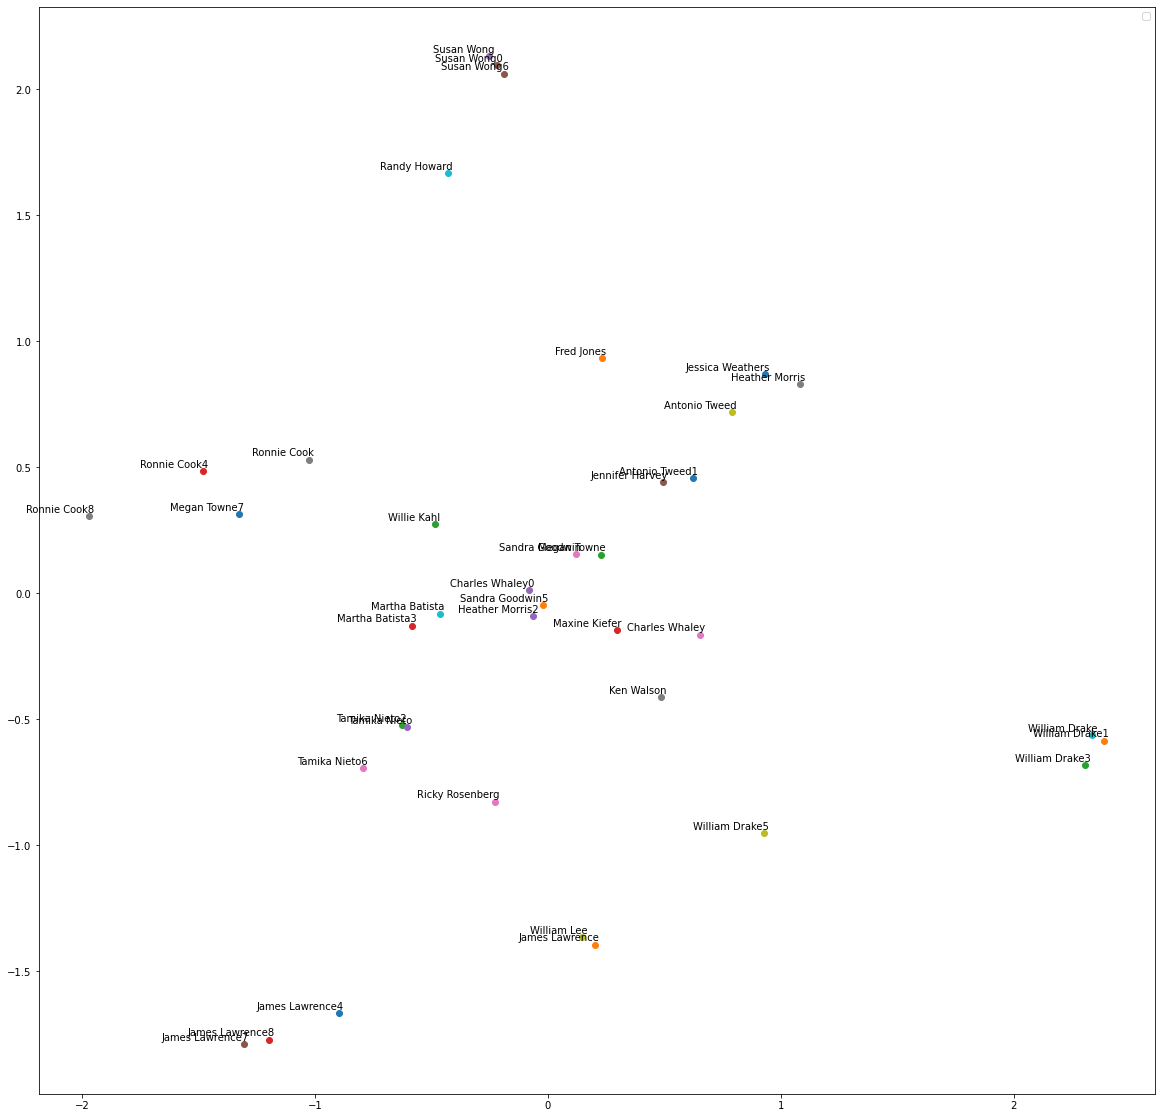

In [66]:
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt

keyedvectors = w2v_model.wv
words = [word for word in keyedvectors.index2word[:]]
embeddings = [keyedvectors[word] for word in words]
pca = PCA(n_components=2, whiten=True)
pca.fit(embeddings)
X_pca = pca.transform(embeddings)

plt.figure(figsize=(20, 20))
for i, label in enumerate(words):
    x,y = X_pca[i]
    plt.scatter(x,y)
    plt.annotate(number2name[label], xy=(x, y), xytext=(5, 2), textcoords='offset points',
                  ha='right', va='bottom')
plt.legend()
plt.show()


In [26]:
names = {0: 'James Lawrence', 1: 'William Lee', 2: 'Fred Jones', 3: 'Charles Whaley', 4: 'Willie Kahl', 5: 'Jessica Weathers', 6: 'Ronnie Cook', 7: 'Heather Morris', 8: 'Susan Wong', 9: 'Tamika Nieto', 10: 'Ricky Rosenberg', 11: 'Jennifer Harvey', 12: 'Megan Towne', 13: 'Antonio Tweed', 14: 'Ken Walson', 15: 'Martha Batista', 16: 'Sandra Goodwin', 17: 'Maxine Kiefer', 18: 'Randy Howard', 19: 'William Drake'}

# v1 original version of cdr generator. Friendships are not necessarily bidirectional
#friends = {0: [17, 7, 10, 1], 1: [10, 12], 2: [6, 18, 10], 3: [15, 12], 4: [14, 8, 7, 17], 5: [8, 18, 13, 12], 6: [7, 4, 16], 7: [2, 1, 3], 8: [5, 13], 9: [2, 12, 19, 14], 10: [8, 17, 0, 3], 11: [17, 8, 10, 3], 12: [13, 5, 14], 13: [8, 16], 14: [16, 3], 15: [9, 16, 19, 6], 16: [11, 5], 17: [16, 0, 19, 10], 18: [0, 3, 11], 19: [7, 1, 18]}

# v2 en v3 en v5 (10 shuffels, 300 calls per shuffel) friendships are bidirectional
friends = {17: [0, 4, 14, 15], 7: [0, 4, 6], 10: [0, 1, 3, 15], 1: [0, 10, 9], 0: [17, 7, 10, 1, 14, 19], 8: [2, 4, 5, 15], 6: [2, 3, 7], 18: [2, 5], 2: [8, 6, 18, 11], 15: [3, 8, 17, 10], 12: [3, 5, 19], 3: [10, 6, 15, 12, 9], 14: [4, 17, 0], 4: [14, 8, 7, 17], 13: [5, 11, 16], 5: [8, 18, 13, 12, 11], 9: [1, 3, 16], 19: [11, 12, 0], 11: [5, 13, 19, 2], 16: [13, 9]}

# v4 only friend pairs
# friends = {0: [1], 1: [0], 2: [3], 3: [2], 4: [5], 5: [4], 6: [7], 7: [6], 8: [9], 9: [8], 10: [11], 11: [10], 12: [13], 13: [12], 14: [15], 15: [14], 16: [17], 17: [16], 18: [19], 19: [18]}

N=20

for namenr in range(0,N):
  print('%d %s has friends:' % (namenr,names[namenr]),end='')
  for friend in friends[namenr]:
    print(' %s,' % names[friend],end='')
  print()

0 James Lawrence has friends: Maxine Kiefer, Heather Morris, Ricky Rosenberg, William Lee, Ken Walson, William Drake,
1 William Lee has friends: James Lawrence, Ricky Rosenberg, Tamika Nieto,
2 Fred Jones has friends: Susan Wong, Ronnie Cook, Randy Howard, Jennifer Harvey,
3 Charles Whaley has friends: Ricky Rosenberg, Ronnie Cook, Martha Batista, Megan Towne, Tamika Nieto,
4 Willie Kahl has friends: Ken Walson, Susan Wong, Heather Morris, Maxine Kiefer,
5 Jessica Weathers has friends: Susan Wong, Randy Howard, Antonio Tweed, Megan Towne, Jennifer Harvey,
6 Ronnie Cook has friends: Fred Jones, Charles Whaley, Heather Morris,
7 Heather Morris has friends: James Lawrence, Willie Kahl, Ronnie Cook,
8 Susan Wong has friends: Fred Jones, Willie Kahl, Jessica Weathers, Martha Batista,
9 Tamika Nieto has friends: William Lee, Charles Whaley, Sandra Goodwin,
10 Ricky Rosenberg has friends: James Lawrence, William Lee, Charles Whaley, Martha Batista,
11 Jennifer Harvey has friends: Jessica Weat

In [67]:
for personnr in names:
  personname = names[personnr]
  print('%d. Friends of %s:' % (personnr,personname),end='')
  for relations in friends[personnr]:
    print('%s, ' % names[relations],end='')
  print()

  print('The following persons are similar to %s:' %  personname)
  for similar_person in w2v_model.most_similar(positive=[name2number[personname]],topn=5):
    print('%s (%f)' % (number2name[similar_person[0]],similar_person[1]))
  print()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  if __name__ == '__main__':
INFO - 16:59:06: precomputing L2-norms of word weight vectors


0. Friends of James Lawrence:Maxine Kiefer, Heather Morris, Ricky Rosenberg, William Lee, Ken Walson, William Drake, 
The following persons are similar to James Lawrence:
James Lawrence7 (0.344027)
James Lawrence4 (0.318841)
James Lawrence8 (0.304564)
Ken Walson (0.267520)
William Drake1 (0.244463)

1. Friends of William Lee:James Lawrence, Ricky Rosenberg, Tamika Nieto, 
The following persons are similar to William Lee:
Ricky Rosenberg (0.400014)
Sandra Goodwin5 (0.272043)
Sandra Goodwin (0.256381)
James Lawrence4 (0.236591)
Tamika Nieto (0.227711)

2. Friends of Fred Jones:Susan Wong, Ronnie Cook, Randy Howard, Jennifer Harvey, 
The following persons are similar to Fred Jones:
Randy Howard (0.366364)
Jessica Weathers (0.215182)
Ronnie Cook4 (0.200506)
Ronnie Cook (0.185997)
Susan Wong0 (0.170762)

3. Friends of Charles Whaley:Ricky Rosenberg, Ronnie Cook, Martha Batista, Megan Towne, Tamika Nieto, 
The following persons are similar to Charles Whaley:
Martha Batista (0.391409)
Charles